In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants

# Open SOS Measurement Dataset, extract measurements

In [131]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)

In [132]:
vars = [
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')

assert len(vars) == len(pivot_df.columns.unique())

In [133]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Calculate 3D divergence

## Define area of the triangular prism faces

In [134]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
VOLUME = A4*7*units('m')
A1, A2, A3, A4, A5, VOLUME

(259 <Unit('meter ** 2')>,
 259 <Unit('meter ** 2')>,
 259 <Unit('meter ** 2')>,
 580.2 <Unit('meter ** 2')>,
 580.2 <Unit('meter ** 2')>,
 4061.4000000000005 <Unit('meter ** 3')>)

## Define normal vectors to the triangular prism faces

In [135]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

## Calculate prism-face normal vectors from instrument GPS data

In [136]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

In [137]:
import geopandas as gpd
instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

x             y           z  \
height tower                                           
1      c      329002.47110  4.312171e+06  2861.36010   
       d      329016.77615  4.312158e+06  2860.09135   
       ue     329005.76010  4.312190e+06  2862.19275   
       uw     328983.46715  4.312165e+06  2860.54055   
2      c      329002.49025  4.312171e+06  2862.28475   
3      c      329002.53920  4.312171e+06  2863.30060   
       d      329016.82015  4.312158e+06  2862.02455   
       ue     329005.80410  4.312190e+06  2864.12270   
       uw     328983.52075  4.312165e+06  2862.50290   
5      c      329002.53790  4.312171e+06  2865.33380   
10     c      329002.65185  4.312171e+06  2870.36580   
       d      329016.90980  4.312158e+06  2868.59560   
       ue     329005.87765  4.312190e+06  2870.70875   
       uw     328983.59905  4.312165e+06  2869.09490   
15     c      329002.72120  4.312171e+06  2875.37755   
20     c      329002.80045  4.312171e+06  2880.25445   

                                              geometry  
height tower                                            
1      c      POINT Z (-106.97306 38.94181 2861.36010)  
       d      POINT Z (-106.97289 38.94170 2860.09135)  
       ue     POINT Z (-106.97302 38.94199 2862.19275)  
       uw     POINT Z (-106.97328 38.94176 2860.54055)  
2      c      POINT Z (-106.97306 38.94181 2862.28475)  
3      c      POINT Z (-106.97306 38.94181 2863.30060)  
       d      POINT Z (-106.97289 38.94170 2862.02455)  
       ue     POINT Z (-106.97302 38.94199 2864.12270)  
       uw     POINT Z (-106.97327 38.94176 2862.50290)  
5      c      POINT Z (-106.97306 38.94181 2865.33380)  
10     c      POINT Z (-106.97306 38.94181 2870.36580)  
       d      POINT Z (-106.97289 38.94170 2868.59560)  
       ue     POINT Z (-106.97302 38.94199 2870.70875)  
       uw     POINT Z (-106.97327 38.94176 2869.09490)  
15     c      POINT Z (-106.97305 38.94182 2875.37755)  
20     c      POINT Z (-106.97305 38.94182 2880.25445)

## Calculate storage change term

In [138]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [139]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

1800 second


In [140]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

### Add to dataset

In [141]:
pivot_df = pivot_df.join(
    storage_change_term['delta water storage (g/s)']
).join(
    storage_change_term['absolute humidity (g/m^3)']
)

# Calculate wind divergence (air mass continuity)

In [142]:
wind_vector_3m_ue = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_10m_ue = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_3m_uw = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_10m_uw = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_3m_c = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_10m_c = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_3m_d = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]
wind_vector_10m_d = [tuple(v) for v in pivot_df[['u_3m_ue', 'v_3m_ue', 'w_3m_ue']].values]


In [143]:
n1_3d = np.array([ n1[0].magnitude, n1[1].magnitude, 0])
n2_3d = np.array([ n2[0].magnitude, n2[1].magnitude, 0])
n3_3d = np.array([ n3[0].magnitude, n3[1].magnitude, 0])
n4_3d = np.array([ 0,   0,  1])
n5_3d = np.array([ 0,   0,  -1])

In [144]:
wind_vector_3m_ue_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_3m_ue])
wind_vector_3m_ue_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_3m_ue])
wind_vector_3m_ue_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_3m_ue])
wind_vector_3m_ue_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_3m_ue])
wind_vector_3m_ue_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_3m_ue])
wind_vector_10m_ue_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_10m_ue])
wind_vector_10m_ue_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_10m_ue])
wind_vector_10m_ue_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_10m_ue])
wind_vector_10m_ue_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_10m_ue])
wind_vector_10m_ue_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_10m_ue])

wind_vector_3m_uw_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_3m_uw])
wind_vector_3m_uw_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_3m_uw])
wind_vector_3m_uw_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_3m_uw])
wind_vector_3m_uw_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_3m_uw])
wind_vector_3m_uw_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_3m_uw])
wind_vector_10m_uw_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_10m_uw])
wind_vector_10m_uw_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_10m_uw])
wind_vector_10m_uw_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_10m_uw])
wind_vector_10m_uw_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_10m_uw])
wind_vector_10m_uw_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_10m_uw])

wind_vector_3m_c_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_3m_c])
wind_vector_3m_c_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_3m_c])
wind_vector_3m_c_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_3m_c])
wind_vector_3m_c_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_3m_c])
wind_vector_3m_c_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_3m_c])
wind_vector_10m_c_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_10m_c])
wind_vector_10m_c_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_10m_c])
wind_vector_10m_c_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_10m_c])
wind_vector_10m_c_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_10m_c])
wind_vector_10m_c_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_10m_c])

wind_vector_3m_d_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_3m_d])
wind_vector_3m_d_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_3m_d])
wind_vector_3m_d_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_3m_d])
wind_vector_3m_d_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_3m_d])
wind_vector_3m_d_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_3m_d])
wind_vector_10m_d_n1 = np.array([np.dot(np.array(vec), n1_3d) for vec in wind_vector_10m_d])
wind_vector_10m_d_n2 = np.array([np.dot(np.array(vec), n2_3d) for vec in wind_vector_10m_d])
wind_vector_10m_d_n3 = np.array([np.dot(np.array(vec), n3_3d) for vec in wind_vector_10m_d])
wind_vector_10m_d_n4 = np.array([np.dot(np.array(vec), n4_3d) for vec in wind_vector_10m_d])
wind_vector_10m_d_n5 = np.array([np.dot(np.array(vec), n5_3d) for vec in wind_vector_10m_d])

In [145]:
face1_avg_wind_thru = 0.25*np.array(
    wind_vector_3m_uw_n1 + 
    wind_vector_10m_uw_n1 + 
    wind_vector_3m_d_n1 + 
    wind_vector_10m_d_n1
)
face2_avg_wind_thru = 0.25*np.array(
    wind_vector_3m_ue_n2 + 
    wind_vector_10m_ue_n2 + 
    wind_vector_3m_d_n2 + 
    wind_vector_10m_d_n2
)
face3_avg_wind_thru = 0.25*np.array(
    wind_vector_3m_uw_n3 + 
    wind_vector_10m_uw_n3 + 
    wind_vector_3m_ue_n3 + 
    wind_vector_10m_ue_n3
)

# face 5
face5_avg_wind_thru = 0.25*np.array(
    wind_vector_3m_uw_n5 + 
    wind_vector_3m_ue_n5 + 
    wind_vector_3m_c_n5 + 
    wind_vector_3m_d_n5
)

# face 4
face4_avg_wind_thru = 0.25*np.array(
    wind_vector_10m_uw_n4 + 
    wind_vector_10m_ue_n4 + 
    wind_vector_10m_c_n4 + 
    wind_vector_10m_d_n4
)

face1_avg_wind_thru_integrated = face1_avg_wind_thru * A1
face2_avg_wind_thru_integrated = face2_avg_wind_thru * A2
face3_avg_wind_thru_integrated = face3_avg_wind_thru * A3
face5_avg_wind_thru_integrated = face5_avg_wind_thru * A5
face4_avg_wind_thru_integrated = face4_avg_wind_thru * A4

wind_divergence_integrated = (face1_avg_wind_thru_integrated + face2_avg_wind_thru_integrated 
    + face3_avg_wind_thru_integrated + face5_avg_wind_thru_integrated 
    + face4_avg_wind_thru_integrated)

In [146]:
pivot_df['wind_divergence_integrated'] = wind_divergence_integrated

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/4147053032.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df['wind_divergence_integrated'].groupby(pivot_df.index.floor('30T').time).mean().plot()


<Axes: xlabel='time'>

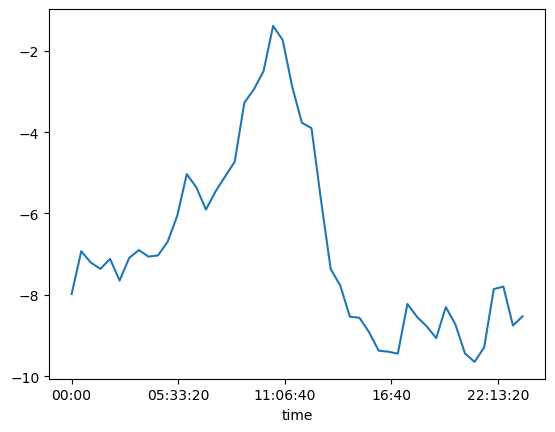

In [147]:
pivot_df['wind_divergence_integrated'].groupby(pivot_df.index.floor('30T').time).mean().plot()

## Calculate turbulent divergence

In [148]:
face1_projected_flux = 0.25*(
    np.dot(pivot_df[['u_h2o__3m_uw', 'v_h2o__3m_uw']].values * units('g/m^2/s'),    n1) +
    np.dot(pivot_df[['u_h2o__10m_uw', 'v_h2o__10m_uw']].values * units('g/m^2/s'),  n1) +
    np.dot(pivot_df[['u_h2o__3m_d', 'v_h2o__3m_d']].values * units('g/m^2/s'),      n1) +
    np.dot(pivot_df[['u_h2o__10m_d', 'v_h2o__10m_d']].values * units('g/m^2/s'),    n1) 
)
face2_projected_flux = 0.25*(
    np.dot(pivot_df[['u_h2o__3m_ue', 'v_h2o__3m_ue']].values * units('g/m^2/s'),    n2) +
    np.dot(pivot_df[['u_h2o__10m_ue', 'v_h2o__10m_ue']].values * units('g/m^2/s'),  n2) +
    np.dot(pivot_df[['u_h2o__3m_d', 'v_h2o__3m_d']].values * units('g/m^2/s'),      n2) +
    np.dot(pivot_df[['u_h2o__10m_d', 'v_h2o__10m_d']].values * units('g/m^2/s'),    n2)
)
face3_projected_flux = 0.25*(
    np.dot(pivot_df[['u_h2o__3m_uw', 'v_h2o__3m_uw']].values * units('g/m^2/s'),    n3) +
    np.dot(pivot_df[['u_h2o__10m_uw', 'v_h2o__10m_uw']].values * units('g/m^2/s'),  n3) +
    np.dot(pivot_df[['u_h2o__3m_ue', 'v_h2o__3m_ue']].values * units('g/m^2/s'),    n3) +
    np.dot(pivot_df[['u_h2o__10m_ue', 'v_h2o__10m_ue']].values * units('g/m^2/s'),  n3)
)

# face 4
face4_projected_flux = 0.25*(
    pivot_df['w_h2o__10m_ue'].values * units('g/m^2/s') +
    pivot_df['w_h2o__10m_uw'].values * units('g/m^2/s') +
    pivot_df['w_h2o__10m_d'].values * units('g/m^2/s') +
    pivot_df['w_h2o__10m_c'].values * units('g/m^2/s')
)

# face 5
face5_projected_flux = - 0.25*(
    pivot_df['w_h2o__3m_ue'].values * units('g/m^2/s') +
    pivot_df['w_h2o__3m_uw'].values * units('g/m^2/s') +
    pivot_df['w_h2o__3m_d'].values * units('g/m^2/s') +
    pivot_df['w_h2o__3m_c'].values * units('g/m^2/s')
)

In [149]:
total_lateral_divergence = (
    face1_projected_flux*A1 + 
    face2_projected_flux*A2 + 
    face3_projected_flux*A3
) / VOLUME
display(total_lateral_divergence)

total_vertical_divergence = (face4_projected_flux*A4 + face5_projected_flux*A5) / VOLUME
display(total_vertical_divergence)

total_divergence = total_lateral_divergence + total_vertical_divergence
display(total_divergence)

Magnitude,[-7.548370466206317e-05 -0.0002490217870753895 7.475581503513882e-05 ... -0.0008348295207683016 -0.00018036999493333187 -2.1846072405500616e-05]
Units,gram/(meter3 second)


Magnitude,[0.00010371441248379594 0.00013496634359615585 2.630053395103993e-05 ... -0.0006152054791672462 -0.0005437580482305005 -3.7676541602400606e-05]
Units,gram/(meter3 second)


Magnitude,[2.8230707821732778e-05 -0.00011405544347923365 0.00010105634898617876 ... -0.0014500349999355478 -0.0007241280431638324 -5.952261400790122e-05]
Units,gram/(meter3 second)


### Add to dataset

In [150]:
pivot_df['total_turb_lateral_divergence (g/s)'] = total_lateral_divergence
pivot_df['total_turb_vertical_divergence (g/s)'] = total_vertical_divergence
pivot_df['total_turb_divergence (g/s)'] = total_divergence

## Calculate advective divergence

In [151]:
abs_humidity_3m = pivot_df['specifichumidity_3m_c'].values * units('g/g') * pivot_df['airdensity_3m_c'].values * units("kg/m^3")
abs_humidity_10m = pivot_df['specifichumidity_10m_c'].values * units('g/g') * pivot_df['airdensity_10m_c'].values * units("kg/m^3")

# make the u components negative, which is necessary 
#   for the coord. system we are working in

advective_flux_u_3m_ue = pivot_df['u_3m_ue'].values * units('m/s') * abs_humidity_3m
advective_flux_v_3m_ue = pivot_df['v_3m_ue'].values * units('m/s') * abs_humidity_3m
advective_flux_u_10m_ue = pivot_df['u_10m_ue'].values * units('m/s') * abs_humidity_10m
advective_flux_v_10m_ue = pivot_df['v_10m_ue'].values * units('m/s') * abs_humidity_10m

advective_flux_u_3m_uw = pivot_df['u_3m_uw'].values * units('m/s') * abs_humidity_3m
advective_flux_v_3m_uw = pivot_df['v_3m_uw'].values * units('m/s') * abs_humidity_3m
advective_flux_u_10m_uw = pivot_df['u_10m_uw'].values * units('m/s') * abs_humidity_10m
advective_flux_v_10m_uw = pivot_df['v_10m_uw'].values * units('m/s') * abs_humidity_10m

advective_flux_u_3m_d = pivot_df['u_3m_d'].values * units('m/s') * abs_humidity_3m
advective_flux_v_3m_d = pivot_df['v_3m_d'].values * units('m/s') * abs_humidity_3m
advective_flux_u_10m_d = pivot_df['u_10m_d'].values * units('m/s') * abs_humidity_10m
advective_flux_v_10m_d = pivot_df['v_10m_d'].values * units('m/s') * abs_humidity_10m

advective_flux_w_3m_ue = pivot_df['w_3m_ue'].values * units('m/s') * abs_humidity_3m
advective_flux_w_3m_uw = pivot_df['w_3m_uw'].values * units('m/s') * abs_humidity_3m
advective_flux_w_3m_d = pivot_df['w_3m_d'].values * units('m/s') * abs_humidity_3m
advective_flux_w_3m_c = pivot_df['w_3m_c'].values * units('m/s') * abs_humidity_3m

advective_flux_w_10m_ue = pivot_df['w_10m_ue'].values * units('m/s') * abs_humidity_10m
advective_flux_w_10m_uw = pivot_df['w_10m_uw'].values * units('m/s') * abs_humidity_10m
advective_flux_w_10m_d = pivot_df['w_10m_d'].values * units('m/s') * abs_humidity_10m
advective_flux_w_10m_c = pivot_df['w_10m_c'].values * units('m/s') * abs_humidity_10m

In [152]:
face1_avg_u_flux = 0.25*(
    advective_flux_u_3m_uw +
    advective_flux_u_10m_uw + 
    advective_flux_u_3m_d +
    advective_flux_u_10m_d
) 
face1_avg_v_flux = 0.25*(
    advective_flux_v_3m_uw +
    advective_flux_v_10m_uw + 
    advective_flux_v_3m_d +
    advective_flux_v_10m_d
) 

face2_avg_u_flux = 0.25*(
    advective_flux_u_3m_ue +
    advective_flux_u_10m_ue + 
    advective_flux_u_3m_d +
    advective_flux_u_10m_d
) 
face2_avg_v_flux = 0.25*(
    advective_flux_v_3m_ue +
    advective_flux_v_10m_ue + 
    advective_flux_v_3m_d +
    advective_flux_v_10m_d
) 

face3_avg_u_flux = 0.25*(
    advective_flux_u_3m_uw +
    advective_flux_u_10m_uw + 
    advective_flux_u_3m_ue +
    advective_flux_u_10m_ue
) 
face3_avg_v_flux = 0.25*(
    advective_flux_v_3m_uw +
    advective_flux_v_10m_uw + 
    advective_flux_v_3m_ue +
    advective_flux_v_10m_ue
) 

# face 5
face5_adv_flux = - 0.25*(
    advective_flux_w_3m_ue + 
    advective_flux_w_3m_uw + 
    advective_flux_w_3m_d + 
    advective_flux_w_3m_c
)

# face 4
face4_adv_flux = 0.25*(
    advective_flux_w_10m_ue + 
    advective_flux_w_10m_uw + 
    advective_flux_w_10m_d + 
    advective_flux_w_10m_c
)

In [153]:
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T * face1_avg_v_flux.units

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T * face1_avg_v_flux.units

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T * face1_avg_v_flux.units

In [154]:
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3)

In [155]:
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1 + 
    face2_projected_adv_flux*A2 + 
    face3_projected_adv_flux*A3
) / VOLUME
display(total_lateral_adv_divergence)

total_vertical_adv_divergence = (face4_adv_flux*A4 + face5_adv_flux*A5)  / VOLUME
display(total_vertical_adv_divergence)

total_adv_divergence = total_lateral_adv_divergence + total_vertical_adv_divergence
display(total_adv_divergence)

Magnitude,[8.436020090619281e-06 3.3832412549947983e-06 4.101087464417333e-06 ... 3.5131609181143416e-05 6.193187096904424e-05 4.404962958670482e-05]
Units,kilogram/(meter3 second)


Magnitude,[4.310724636131686e-07 3.3954236069501258e-06 1.6572357028893576e-06 ... 7.348202427390807e-07 -1.3695496313310477e-05 -7.420165353978712e-06]
Units,kilogram/(meter3 second)


Magnitude,[8.86709255423245e-06 6.778664861944924e-06 5.758323167306691e-06 ... 3.58664294238825e-05 4.823637465573377e-05 3.662946423272611e-05]
Units,kilogram/(meter3 second)


In [156]:
np.nanmean(total_lateral_adv_divergence.magnitude), np.nanmedian(total_lateral_adv_divergence.magnitude)

(1.3161578060171062e-05, 1.097381728834035e-05)

In [157]:
np.nanmean(total_lateral_divergence.magnitude), np.nanmedian(total_lateral_divergence.magnitude)

(7.306808158532067e-06, 0.0)

### Add to dataset

In [158]:
total_lateral_adv_divergence

Magnitude,[8.436020090619281e-06 3.3832412549947983e-06 4.101087464417333e-06 ... 3.5131609181143416e-05 6.193187096904424e-05 4.404962958670482e-05]
Units,kilogram/(meter3 second)


In [159]:
pivot_df['total_adv_lateral_divergence (g/s)'] = total_lateral_adv_divergence.to("g/m^3/s")
pivot_df['total_adv_vertical_divergence (g/s)'] = total_vertical_adv_divergence.to("g/m^3/s")
pivot_df['total_adv_divergence (g/s)'] = total_adv_divergence.to("g/m^3/s")

## Calculate residual/source term

$\frac{dq}{dt} = S_{BS} - \nabla \cdot \overline{u_i} \space \overline{q} - \nabla \cdot \overline{u_i' q'}$

$S_{BS} = \frac{dq}{dt} + \nabla \cdot \overline{u_i} \space \overline{q} + \nabla \cdot \overline{u_i' q'}$

In [160]:
pivot_df['source (g/s)'] = pivot_df['total_adv_divergence (g/s)'] + pivot_df['total_turb_divergence (g/s)'] + pivot_df['delta water storage (g/s)']

# Correlation matrix

In [161]:
pd.set_option('display.max_rows', 200)
pivot_df.corr()[['source (g/s)']].sort_values('source (g/s)')

,source (g/s)
u_10m_d,-0.084293
u_10m_c,-0.084195
u_3m_ue,-0.083335
u_10m_ue,-0.082672
u_5m_c,-0.082045
u_15m_c,-0.082006
u_3m_d,-0.081943
u_20m_c,-0.081487
v_h2o__5m_c,-0.081153
u_3m_c,-0.081083


## Calculate EC-estimated surface sublimation 

We assume the 2m EC vertical flux equals surface sublimation

In [162]:
surface_sublimation = pivot_df['w_h2o__2m_c'].values * units('g/m^2/s') * A4

pivot_df['EC-estimated surface sublimation (g/s)'] = surface_sublimation
pivot_df['EC-estimated surface sublimation (g/m^2/s)'] = pivot_df['w_h2o__2m_c'].values

## Calculate Control-Volume estimated surface sublimation

In [163]:
## Calculate estimation of surface sublimation assuming that the 3 and 10m sonics represent fluxes all the way to the ground (10m tall control volume)
# AREAS AND VOLUMES
# Define face areas
NEW_A1 = NEW_A2 = NEW_A3 = 37 * 10 * units('m^2')
NEW_A4 = NEW_A5 = 580.2 * units('m^2')
NEW_VOLUME = A4*10*units('m')


surface_sublimation = (
    - (( pivot_df['delta water storage (g/s)'].values* units('g/s') / VOLUME ) * NEW_VOLUME) 
    - face1_projected_flux*NEW_A1
    - face2_projected_flux*NEW_A2
    - face3_projected_flux*NEW_A3
    - face4_projected_flux*NEW_A4
    - face1_projected_adv_flux*NEW_A1
    - face2_projected_adv_flux*NEW_A2
    - face3_projected_adv_flux*NEW_A3
    - face4_adv_flux*NEW_A4
)

pivot_df['CV-estimated surface sublimation (g/s)'] = surface_sublimation
pivot_df['CV-estimated surface sublimation (g/m^2/s)'] = surface_sublimation / A4

<Axes: xlabel='time'>

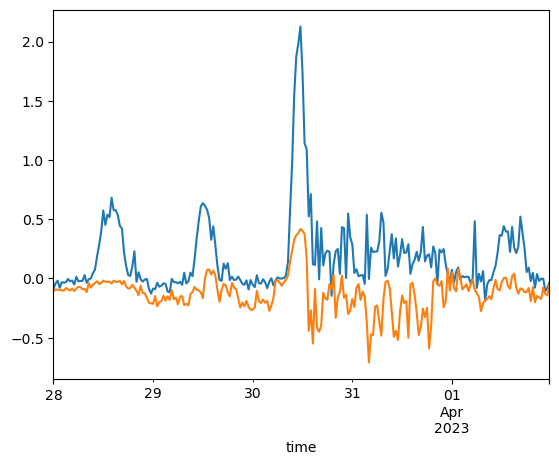

In [164]:
(pivot_df.loc['20230328': '20230401']['EC-estimated surface sublimation (g/m^2/s)'].head(1800)*100).plot()
pivot_df.loc['20230328': '20230401']['CV-estimated surface sublimation (g/m^2/s)'].head(1800).plot()

# Plot: Average diurnal cycles

In [165]:
import xarray as xr
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

In [166]:
src = pivot_df[[
    'delta water storage (g/s)', 
    'absolute humidity (g/m^3)',
    # 'wind_divergence_integrated',
    'source (g/s)',
    # 'EC-estimated surface sublimation (g/s)',

    'total_turb_lateral_divergence (g/s)',
    'total_turb_vertical_divergence (g/s)', 
    'total_turb_divergence (g/s)',

    'total_adv_lateral_divergence (g/s)',
    'total_adv_vertical_divergence (g/s)', 
    'total_adv_divergence (g/s)',

]]
nobs_src = src[src.index.isin(nobs_times)]
bs_src = src[src.index.isin(bs_times)]
snowing_src = src[src.index.isin(is_snowing_dates)]
not_snowing_src = src[src.index.isin(is_not_snowing_dates)]
not_snowing_nobs_src = src[src.index.isin(set(is_not_snowing_dates).intersection(set(nobs_times)))]

src = pd.concat([
    # nobs_src.groupby([nobs_src.index.floor('30T').time]).mean().assign(type='No BS'),
    # bs_src.groupby([bs_src.index.floor('30T').time]).mean().assign(type='BS'),
    # src.groupby([src.index.floor('30T').time]).mean().assign(type='All data'),
    # snowing_src.groupby([snowing_src.index.floor('30T').time]).mean().assign(type='Snowing'),
    # not_snowing_src.groupby([not_snowing_src.index.floor('30T').time]).mean().assign(type='Not snowing'),
    not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),
])

src.index.name = 'time'
src
src = src.melt(ignore_index=False, id_vars=['type']).reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

conservation_chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('water vapour content (g/s)'),
    alt.Facet('variable:N', columns=3),
    alt.StrokeDash('type:N').scale(
        # domain=['No BS', 'BS', 'All data'], 
        # range=[[1,0], [1,2], [1,4]]
    ),
    # alt.Color('type:N'),
).properties(height = 150, width=300).resolve_scale(y='independent')
conservation_chart


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/2704946948.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [167]:
src = pivot_df[[
    # 'delta water storage (g/s)', 
    # 'absolute humidity (g/m^3)',
    # 'wind_divergence_integrated',
    # 'source (g/s)',
    # 'EC-estimated surface sublimation (g/s)',

    'total_turb_lateral_divergence (g/s)',
    'total_turb_vertical_divergence (g/s)', 
    'total_turb_divergence (g/s)',

    # 'total_adv_lateral_divergence (g/s)',
    # 'total_adv_vertical_divergence (g/s)', 
    # 'total_adv_divergence (g/s)',

]]
nobs_src = src[src.index.isin(nobs_times)]
bs_src = src[src.index.isin(bs_times)]
snowing_src = src[src.index.isin(is_snowing_dates)]
not_snowing_src = src[src.index.isin(is_not_snowing_dates)]
not_snowing_nobs_src = src[src.index.isin(set(is_not_snowing_dates).intersection(set(nobs_times)))]

src = pd.concat([
    # nobs_src.groupby([nobs_src.index.floor('30T').time]).mean().assign(type='No BS'),
    # bs_src.groupby([bs_src.index.floor('30T').time]).mean().assign(type='BS'),
    # src.groupby([src.index.floor('30T').time]).mean().assign(type='All data'),
    # snowing_src.groupby([snowing_src.index.floor('30T').time]).mean().assign(type='Snowing'),
    # not_snowing_src.groupby([not_snowing_src.index.floor('30T').time]).mean().assign(type='Not snowing'),
    not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),
])

src.index.name = 'time'
src
src = src.melt(ignore_index=False, id_vars=['type']).reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

alt.Chart(
    src
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('water vapour content (g/s)').scale(domain=[-60,60]),
    # alt.Facet('variable:N', columns=3),
    alt.Color('variable:N'),
    # alt.Color('type:N'),
).properties(height = 150, width=300).resolve_scale(y='independent').display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3015389902.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [168]:
src = pivot_df[[
    # 'delta water storage (g/s)', 
    # 'absolute humidity (g/m^3)',
    # 'wind_divergence_integrated',
    # 'source (g/s)',
    # 'EC-estimated surface sublimation (g/s)',

    # 'total_turb_lateral_divergence (g/s)',
    # 'total_turb_vertical_divergence (g/s)', 
    # 'total_turb_divergence (g/s)',

    'total_adv_lateral_divergence (g/s)',
    'total_adv_vertical_divergence (g/s)', 
    'total_adv_divergence (g/s)',

]]
nobs_src = src[src.index.isin(nobs_times)]
bs_src = src[src.index.isin(bs_times)]
snowing_src = src[src.index.isin(is_snowing_dates)]
not_snowing_src = src[src.index.isin(is_not_snowing_dates)]
not_snowing_nobs_src = src[src.index.isin(set(is_not_snowing_dates).intersection(set(nobs_times)))]

src = pd.concat([
    # nobs_src.groupby([nobs_src.index.floor('30T').time]).mean().assign(type='No BS'),
    # bs_src.groupby([bs_src.index.floor('30T').time]).mean().assign(type='BS'),
    # src.groupby([src.index.floor('30T').time]).mean().assign(type='All data'),
    # snowing_src.groupby([snowing_src.index.floor('30T').time]).mean().assign(type='Snowing'),
    # not_snowing_src.groupby([not_snowing_src.index.floor('30T').time]).mean().assign(type='Not snowing'),
    not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),
])

src.index.name = 'time'
src
src = src.melt(ignore_index=False, id_vars=['type']).reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

alt.Chart(
    src
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('water vapour content (g/s)').scale(domain=[-60,60]),
    # alt.Facet('variable:N', columns=3),
    alt.Color('variable:N'),
    # alt.Color('type:N'),
).properties(height = 150, width=300).resolve_scale(y='independent').display(renderer='svg')


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/963711818.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  not_snowing_nobs_src.groupby([not_snowing_nobs_src.index.floor('30T').time]).mean().assign(type='Not snowing, No BS'),


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [169]:
src = pivot_df[[
    'Rnet_9m_d',
    'Rsw_in_9m_d'
]].groupby([pivot_df.index.floor('30T').time]).mean()
src = src.melt(ignore_index=False)
src.index.name = 'time'
src = src.reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

rad_chart = alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('radiation (W/m^2)'),
    alt.StrokeDash('variable:N'),
).properties(height = 150, width=300)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3605177993.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ]].groupby([pivot_df.index.floor('30T').time]).mean()


In [170]:
src = pivot_df[[
    'dir_10m_c',
        'dir_10m_d',
        'dir_10m_ue',
        'dir_10m_uw',
        'dir_15m_c',
        'dir_20m_c',
        'dir_2m_c',
        'dir_3m_c',
        'dir_3m_d',
        'dir_3m_ue',
        'dir_3m_uw',
        'dir_5m_c',
]].groupby([pivot_df.index.floor('30T').time]).median()
src = src.melt(ignore_index=False)
src.index.name = 'time'
src = src.reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))
src['height'] = src['variable'].apply(tidy._height_from_variable_name)
src['tower'] = src['variable'].apply(tidy._tower_from_variable_name)

dir_chart = alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('Wind direction (˚)'),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.StrokeDash('tower:N')
).properties(height = 150, width=300)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/2162192833.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ]].groupby([pivot_df.index.floor('30T').time]).median()


In [171]:
src = pivot_df[[
    'w_2m_c',
    'w_3m_c', 'w_3m_d', 'w_3m_ue', 'w_3m_uw',
    'w_5m_c',
    'w_10m_c', 'w_10m_d', 'w_10m_ue', 'w_10m_uw',
    'w_15m_c',
    'w_20m_c',
]].groupby([pivot_df.index.floor('30T').time]).mean()
src = src.melt(ignore_index=False)
src['tower'] = src.variable.apply(tidy._tower_from_variable_name)
src['height'] = src.variable.apply(tidy._height_from_variable_name)
src.index.name = 'time'
src = src.reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

w_chart = alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('velocity (m/s)'),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.StrokeDash('tower:N'),
    tooltip='tower:N'
).properties(height = 150, width=300)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/702322118.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ]].groupby([pivot_df.index.floor('30T').time]).mean()


In [172]:
src = pivot_df[[
    'w_3m_c', 
    'w_10m_c',
]].groupby([pivot_df.index.floor('30T').time]).mean()
src = src.melt(ignore_index=False)
src['tower'] = src.variable.apply(tidy._tower_from_variable_name)
src['height'] = src.variable.apply(tidy._height_from_variable_name)
src['measurement'] = src.variable.apply(tidy._measurement_from_variable_name)
src.index.name = 'time'
src = src.reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

w_simple_chart = alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('velocity (m/s)'),
    alt.Color('height:O'),
    alt.Column('measurement:N').sort(['w', 'specific humidity'])
).properties(height = 150, width=300).resolve_scale(y='independent')

src = pivot_df[[
    'specifichumidity_3m_c', 
    'specifichumidity_10m_c',
]].groupby([pivot_df.index.floor('30T').time]).mean()

# convert from g/g to g/kg
pivot_df[[
    'specifichumidity_3m_c', 
    'specifichumidity_10m_c',
]] = pivot_df[[
    'specifichumidity_3m_c', 
    'specifichumidity_10m_c',
]]*1000 
src = src.melt(ignore_index=False)
src['tower'] = src.variable.apply(tidy._tower_from_variable_name)
src['height'] = src.variable.apply(tidy._height_from_variable_name)
src['measurement'] = src.variable.apply(tidy._measurement_from_variable_name)
src.index.name = 'time'
src = src.reset_index()
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))

q_simple_chart = alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('specific humidity (g/kg)'),
    alt.Color('height:O'),
    alt.Column('measurement:N').sort(['w', 'specific humidity'])
).properties(height = 150, width=300).resolve_scale(y='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3691568501.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ]].groupby([pivot_df.index.floor('30T').time]).mean()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3691568501.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ]].groupby([pivot_df.index.floor('30T').time]).mean()


In [173]:
src = pivot_df[[
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',
]]
src = src.groupby([pivot_df.index.floor('30T').time]).mean().melt(ignore_index=False).reset_index().rename(columns={'index': 'time'})
src['height'] = src.variable.apply(tidy._height_from_variable_name)
src['height_low'] = src['height'] - 0.5
src['height_hi'] = src['height'] + 0.5
src.time = src.time.apply(lambda time: dt.datetime.combine(dt.date(2024, 1, 1),  time))
src['time_hi'] = src['time'].apply(lambda dis: dis + dt.timedelta(minutes=30)) 
temp_heatmap = alt.Chart(src).mark_rect().encode(
    alt.X('time:T').title('time').axis(format='%H:%M'),
    alt.X2('time_hi:T'),
    alt.Y('height_low:Q').scale(zero=False, domain=[0,20]).title("height (m)"),
    alt.Y2('height_hi:Q'),
    alt.Color('value:Q').title('Temperature (˚C)').scale(scheme='viridis'),
).properties(width = 400, height = 200, title='Average Diurnal Temperature Profile')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_19951/3555904380.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src.groupby([pivot_df.index.floor('30T').time]).mean().melt(ignore_index=False).reset_index().rename(columns={'index': 'time'})


In [174]:

(
    (conservation_chart)
    &
    (w_chart | w_simple_chart | q_simple_chart).resolve_scale(color='shared', strokeDash='shared')
    &
    (dir_chart | rad_chart).resolve_scale(color='independent', strokeDash='independent')
    &
    temp_heatmap
).resolve_scale(x='independent', color='independent', strokeDash='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Hovmoller plots of similar stuff

In [175]:
columns = [
    # 'source (g/s)',
    'total_turb_lateral_divergence (g/s)',
    'total_turb_vertical_divergence (g/s)',
    'total_turb_divergence (g/s)',
    'total_adv_lateral_divergence (g/s)',
    'total_adv_vertical_divergence (g/s)',
    'total_adv_divergence (g/s)'
]
src = pivot_df[columns].reset_index()
src['date'] = src['time'].apply(lambda dt: dt.replace(hour = 0, minute = 0, second = 0))
src['date_upper'] = src.time + dt.timedelta(hours=24)
src['hour'] = src.time.dt.hour + src.time.dt.minute.astype('float')/60
src['hour_upper'] = src['hour'] + 0.5
src
alt.Chart(src).transform_fold(columns).mark_rect().encode(
    alt.X('hour:Q').title('hour'),
    alt.X2('hour_upper:Q'),
    alt.Y('date:T').title('date'),
    alt.Y2('date_upper:T'),
    alt.Color("value:Q").scale(type='symlog', scheme='purpleorange').title("Divergence (g/s)"),
    alt.Facet("key:N", columns=3)
).resolve_scale(color='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [176]:
columns = [
    # 'source (g/s)',
    # 'total_turb_lateral_divergence (g/s)',
    # 'total_turb_vertical_divergence (g/s)',
    # 'total_turb_divergence (g/s)',
    'total_adv_lateral_divergence (g/s)',
    'total_adv_vertical_divergence (g/s)',
    'total_adv_divergence (g/s)'
]
src = not_snowing_nobs_src[columns].reset_index()
src['date'] = src['time'].apply(lambda dt: dt.replace(hour = 0, minute = 0, second = 0))
src['date_upper'] = src.time + dt.timedelta(hours=24)
src['hour'] = src.time.dt.hour + src.time.dt.minute.astype('float')/60
src['hour_upper'] = src['hour'] + 0.5
src
alt.Chart(src).transform_fold(columns).mark_rect().encode(
    alt.X('hour:Q').title('hour'),
    alt.X2('hour_upper:Q'),
    alt.Y('date:T').title('date'),
    alt.Y2('date_upper:T'),
    alt.Color("value:Q").scale(type='symlog', scheme='purpleorange').title("Divergence (g/s)"),
    alt.Facet("key:N", columns=3)
).resolve_scale(color='independent').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Plot: Case studies

In [177]:
(
    alt.Chart(
        tidy_df.query("variable == 'SF_avg_ue'").set_index('time').loc[
            '20221220':'20221223'
        ].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'),
        alt.Y('value:Q')
    ).properties(width = 300, height = 125) 
    
    &
    
    alt.Chart(
        pivot_df[[
            'delta water storage (g/s)',
            'total_turb_divergence (g/s)',
            'total_adv_divergence (g/s)'
]].loc['20221220':'20221223'].melt(ignore_index=False).reset_index()
    ).transform_window(
        rolling_avg = "mean(value)",
        frame = [-2, 2],
        groupby = ['variable']
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("rolling_avg:Q").scale(),
        alt.Color("variable:N")
    ).properties(width = 300, height = 125)
) | (
    alt.Chart(
        tidy_df.query("variable == 'SF_avg_ue'").set_index('time').loc[
            '20221211':'20221214'
        ].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'),
        alt.Y('value:Q')
    ).properties(width = 300, height = 125) 
    
    &
    
    alt.Chart(
        pivot_df[[
            'delta water storage (g/s)',
            'total_turb_divergence (g/s)',
            'total_adv_divergence (g/s)'
        ]].loc['20221211':'20221214'].melt(ignore_index=False).reset_index()
    ).transform_window(
        rolling_avg = "mean(value)",
        frame = [-2, 2],
        groupby = ['variable']
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("rolling_avg:Q").scale(),
        alt.Color("variable:N")
    ).properties(width = 300, height = 125)   
) | (
    alt.Chart(
        tidy_df.query("variable == 'SF_avg_ue'").set_index('time').loc[
            '20230328':'20230331    '
        ].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'),
        alt.Y('value:Q')
    ).properties(width = 300, height = 125) 
    
    &
    
    alt.Chart(
        pivot_df[[
            'delta water storage (g/s)',
            'total_turb_divergence (g/s)',
            'total_adv_divergence (g/s)'
]].loc['20230328':'20230331 '].melt(ignore_index=False).reset_index()
    ).transform_window(
        rolling_avg = "mean(value)",
        frame = [-2, 2],
        groupby = ['variable']
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("rolling_avg:Q").scale(),
        alt.Color("variable:N")
    ).properties(width = 300, height = 125)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [178]:
day_hours = [7,8,9,10,11,12,13,14,15,16,17,18]
night_hours = [19,20,21,22,23,0,1,2,3,4,5,6]
print('turb. divergence (g/s)',             'all',        round( pivot_df['total_turb_divergence (g/s)'].mean(), 2))
print('turb. divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_turb_divergence (g/s)'].mean(), 2))
print('turb. divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_turb_divergence (g/s)'].mean(), 2))
print('turb. divergence (g/s)',             'bs',         round( pivot_df[  (pivot_df.index.isin(bs_times))    ]['total_turb_divergence (g/s)'].mean(), 2))
print('turb. divergence (g/s)',             'no bs',      round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_turb_divergence (g/s)'].mean(), 2))

print('vertical_turb_divergence (g/s)',    'all',        round( pivot_df['total_turb_vertical_divergence (g/s)'].mean(), 2))
print('vertical_turb_divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_turb_vertical_divergence (g/s)'].mean(), 2))
print('vertical_turb_divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_turb_vertical_divergence (g/s)'].mean(), 2))
print('vertical_turb_divergence (g/s)',    'bs',         round( pivot_df[  (pivot_df.index.isin(bs_times))    ]['total_turb_vertical_divergence (g/s)'].mean(), 2))
print('vertical_turb_divergence (g/s)',    'no bs',      round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_turb_vertical_divergence (g/s)'].mean(), 2))

print('lateral_turb_divergence (g/s)',     'all',        round( pivot_df['total_turb_lateral_divergence (g/s)'].mean(), 2))
print('lateral_turb_divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_turb_lateral_divergence (g/s)'].mean(), 2))
print('lateral_turb_divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_turb_lateral_divergence (g/s)'].mean(), 2))
print('lateral_turb_divergence (g/s)',     'bs',         round( pivot_df[  (pivot_df.index.isin(bs_times))    ]['total_turb_lateral_divergence (g/s)'].mean(), 2))
print('lateral_turb_divergence (g/s)',     'no bs',      round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_turb_lateral_divergence (g/s)'].mean(), 2))

print('adv divergence (g/s)',             'all',    round( pivot_df['total_adv_divergence (g/s)'].mean(), 2))
print('adv divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_adv_divergence (g/s)'].mean(), 2))
print('adv divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_adv_divergence (g/s)'].mean(), 2))
print('adv divergence (g/s)',             'bs',     round( pivot_df[  (pivot_df.index.isin(bs_times))    ]['total_adv_divergence (g/s)'].mean(), 2))
print('adv divergence (g/s)',             'no bs',  round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_adv_divergence (g/s)'].mean(), 2))

print('adv_vertical_divergence (g/s)','all',        round( pivot_df['total_adv_vertical_divergence (g/s)'].mean(), 2))
print('adv_vertical_divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_adv_vertical_divergence (g/s)'].mean(), 2))
print('adv_vertical_divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_adv_vertical_divergence (g/s)'].mean(), 2))
print('adv_vertical_divergence (g/s)','bs',         round( pivot_df[  (    pivot_df.index.isin(bs_times))    ]['total_adv_vertical_divergence (g/s)'].mean(), 2))
print('adv_vertical_divergence (g/s)','no bs',      round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_adv_vertical_divergence (g/s)'].mean(), 2))

print('adv_lateral_divergence (g/s)', 'all',        round( pivot_df['total_adv_lateral_divergence (g/s)'].mean(), 2))
print('adv_lateral_divergence (g/s)',             'day',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(day_hours)  ]['total_adv_lateral_divergence (g/s)'].mean(), 2))
print('adv_lateral_divergence (g/s)',             'night',        round( pivot_df[  (pivot_df.index.isin(bs_times))   & pivot_df.index.hour.isin(night_hours)  ]['total_adv_lateral_divergence (g/s)'].mean(), 2))
print('adv_lateral_divergence (g/s)', 'bs',         round( pivot_df[  (pivot_df.index.isin(bs_times))    ]['total_adv_lateral_divergence (g/s)'].mean(), 2))
print('adv_lateral_divergence (g/s)', 'no bs',      round( pivot_df[  (pivot_df.index.isin(nobs_times))  ]['total_adv_lateral_divergence (g/s)'].mean(), 2))

turb. divergence (g/s) all 0.0
turb. divergence (g/s) day -0.0
turb. divergence (g/s) night 0.0
turb. divergence (g/s) bs 0.0
turb. divergence (g/s) no bs 0.0
vertical_turb_divergence (g/s) all 0.0
vertical_turb_divergence (g/s) day 0.0
vertical_turb_divergence (g/s) night 0.0
vertical_turb_divergence (g/s) bs 0.0
vertical_turb_divergence (g/s) no bs -0.0
lateral_turb_divergence (g/s) all 0.0
lateral_turb_divergence (g/s) day -0.0
lateral_turb_divergence (g/s) night 0.0
lateral_turb_divergence (g/s) bs -0.0
lateral_turb_divergence (g/s) no bs 0.0
adv divergence (g/s) all 0.01
adv divergence (g/s) day 0.02
adv divergence (g/s) night 0.02
adv divergence (g/s) bs 0.02
adv divergence (g/s) no bs 0.01
adv_vertical_divergence (g/s) all 0.0
adv_vertical_divergence (g/s) day -0.0
adv_vertical_divergence (g/s) night 0.0
adv_vertical_divergence (g/s) bs 0.0
adv_vertical_divergence (g/s) no bs 0.0
adv_lateral_divergence (g/s) all 0.01
adv_lateral_divergence (g/s) day 0.02
adv_lateral_divergence (

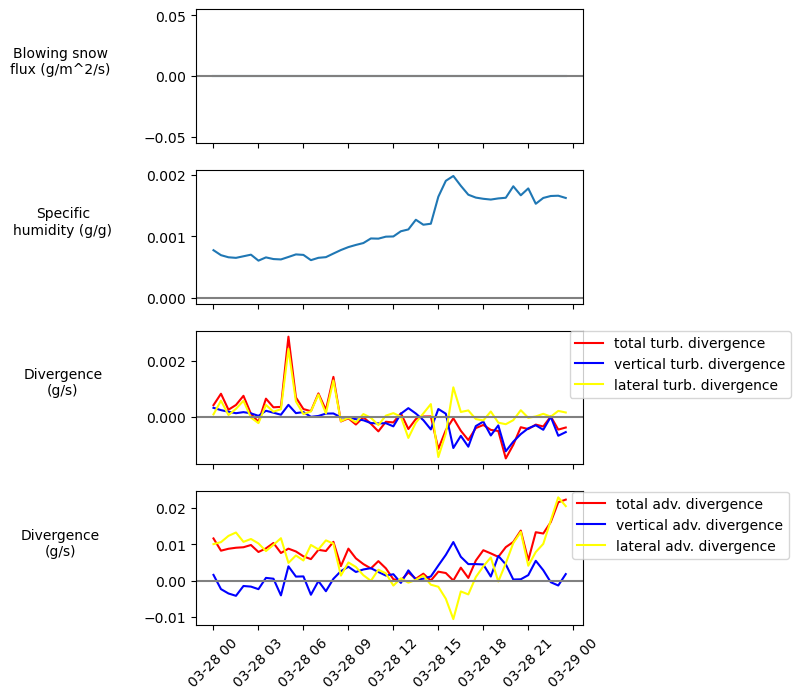

In [179]:
# start_date = '20221221'
# end_date = '20221223'
# start_date = '20221211'
# end_date = '20221214'
start_date = '20230328'
end_date = '20230328'

fig, axes = plt.subplots(4,1, sharex=True, figsize=(5, 8))
axes[0].plot(
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc[start_date:end_date].index,
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc[start_date:end_date].value
)
axes[1].plot(
    tidy_df.query("variable == 'specifichumidity_5m_c'").set_index('time').sort_index().loc[start_date:end_date].index,
    tidy_df.query("variable == 'specifichumidity_5m_c'").set_index('time').sort_index().loc[start_date:end_date].value
)

axes[2].plot(
    pivot_df['total_turb_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_turb_divergence (g/s)'].loc[start_date:end_date],
    color='red',
    label = 'total turb. divergence'
)
axes[2].plot(
    pivot_df['total_turb_vertical_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_turb_vertical_divergence (g/s)'].loc[start_date:end_date],
    color='blue',
    label = 'vertical turb. divergence'
)
axes[2].plot(
    pivot_df['total_turb_lateral_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_turb_lateral_divergence (g/s)'].loc[start_date:end_date],
    color='yellow',
    label = 'lateral turb. divergence'
)

pivot_df['total_adv_lateral_divergence (g/s)']
pivot_df['total_adv_vertical_divergence (g/s)']
pivot_df['total_adv_divergence (g/s)']
         
axes[3].plot(
    pivot_df['total_adv_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_adv_divergence (g/s)'].loc[start_date:end_date],
    color='red',
    label = 'total adv. divergence'
)
axes[3].plot(
    pivot_df['total_adv_vertical_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_adv_vertical_divergence (g/s)'].loc[start_date:end_date],
    color='blue',
    label = 'vertical adv. divergence'
)
axes[3].plot(
    pivot_df['total_adv_lateral_divergence (g/s)'].loc[start_date:end_date].index,
    pivot_df['total_adv_lateral_divergence (g/s)'].loc[start_date:end_date],
    color='yellow',
    label = 'lateral adv. divergence'
)

for ax in axes:
    ax.axhline(0, color='grey')
axes[0].set_ylabel("Blowing snow\nflux (g/m^2/s)", rotation=0, labelpad=60)
axes[1].set_ylabel("Specific\nhumidity (g/g)", rotation=0, labelpad=60)
axes[2].set_ylabel("Divergence\n(g/s)", rotation=0, labelpad=60)
axes[2].legend(loc='upper center', bbox_to_anchor=(1.25, 1.05),ncol=1)
# axes[2].set_ylim(-20,20)

axes[3].set_ylabel("Divergence\n(g/s)", rotation=0, labelpad=60)
axes[3].legend(loc='upper center', bbox_to_anchor=(1.25, 1.05),ncol=1)
# axes[3].set_ylim(-20,20)
axes[3].tick_params(axis='x', labelrotation=45)

In [180]:
pivot_df.to_csv('flux_divergence_3d_control_volume.csv')

# Plot wind vectors in space?

In [ ]:
wind_src = tidy_df[tidy_df.measurement.isin(['wind speed', 'wind direction', 'w'])]
wind_src = wind_src.pivot_table(index=['time', 'height', 'tower'], values='value', columns='measurement').reset_index()
tower_to_x_dict = {
    'ue': 1,
    'uw': 1,
    'c': 3,
    'd': 5,
}
tower_to_y_dict = {
    'ue': 7,
    'uw': 1,
    'c': 4,
    'd': 4,
}
wind_src['x'] = wind_src['tower'].apply(tower_to_x_dict.get)
wind_src['y'] = wind_src['tower'].apply(tower_to_y_dict.get)

wind_src['wind from'] = wind_src['wind direction'] - 180

wind_src

In [ ]:
src = wind_src[wind_src.time  < '20221201']
src = src.query("height == 3")
plot_3m = alt.Chart(src).mark_point(shape='arrow').encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
    alt.Size('wind speed:Q').scale(domain=[0.50,5], range=[500,5000]),
    alt.Angle('wind from:Q').scale(domain=[0,360]),
    alt.Color('w').scale(domain=[-0.1, 0.1], scheme='purpleorange'),
    alt.Facet('time:T', columns=4).header(format='%H:%M')
).properties(width=100, height = 100, title='Winds at 3 meters')

src = wind_src[wind_src.time  < '20221201']
src = src.query("height == 10")
plot_10m = alt.Chart(src).mark_point(shape='arrow').encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
    alt.Size('wind speed:Q').scale(domain=[0.50,5], range=[500,5000]),
    alt.Angle('wind from:Q').scale(domain=[0,360]),
    alt.Color('w').scale(domain=[-0.1, 0.1], scheme='purpleorange'),
    alt.Facet('time:T', columns=4).header(format='%H:%M')
).properties(width=100, height = 100, title='Winds at 10 meters')

(plot_3m | plot_10m).configure_axis(grid=False).configure_legend(columns=2)

# Examine corrections to the gas analyzers

* Scatter plots - hygrometer at 3/5/10/20 m-C vs gas analyzer at 3m C
    * Water vapor content (hygrometer) vs water vapor content (gas analyzer)
    - plot both using their native units (abs humidity vs relative)
    - plot both using absolute humidity
    - plot both converting to specific humidity
    - plot both converting to relative humidity
    * Then can color code by temperature

## Add absolute humidity measurements by converting hygrometer measurements

In [ ]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

## Examine raw measurements

In [ ]:
alt.Chart(
    tidy_df[
        tidy_df.measurement=='absolute humidity'
    ].groupby(['tower', 'height'])[['value']].mean().reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q").title("Absolute humidity (g/m^3)"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

In [ ]:
src =tidy_df[
    tidy_df.measurement.isin(['absolute humidity', 'Water vapor density'])
].query("tower == 'c'").pivot(
    index=['time', 'height', 'tower'],
    columns='measurement',
    values='value'
)
src.columns = src.columns.get_level_values(0)
src = src.reset_index()

alt.Chart(src).mark_circle(opacity=0.15).encode(
    alt.X('Water vapor density').title('Gas analyzer').scale(domain=[0,6], clamp=True),
    alt.Y('absolute humidity').title('Hygrometer').scale(domain=[0,6], clamp=True),
    alt.Row('tower:N'),
    alt.Column('height:O')
)

In [ ]:
src =tidy_df[
    tidy_df.measurement.isin(['temperature', 'absolute humidity', 'Water vapor density'])
].query("tower == 'c'").pivot(
    index=['time', 'height', 'tower'],
    columns='measurement',
    values='value'
)
src.columns = src.columns.get_level_values(0)
src = src.reset_index()
alt.Chart(src).mark_circle(opacity=1.0).encode(
    alt.X('Water vapor density').title('Gas analyzer').scale(domain=[0,6], clamp=True),
    alt.Y('absolute humidity').title('Hygrometer').scale(domain=[0,6], clamp=True),
    alt.Color('temperature').scale(domain=[-30,10], scheme='reds'),
    alt.Row('tower:N'),
    alt.Column('height:O')
)

## Calculate corrections assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [ ]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [ ]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [ ]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

## Update dataset with corrections

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([3,10])]

alt.Chart(
    src[ src.time > '20221220' ][ src.time < '20221224' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

In [ ]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([3,10])]

alt.Chart(
    src[ src.time > '20221220' ][ src.time < '20221224' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

## Examine residuals

In [ ]:
compare_src = tidy_df[tidy_df.variable.isin([
    'T_3m_c', 'h2o_3m_c', 'specifichumidity_3m_c', 'airdensity_3m_c',
    'T_10m_c', 'h2o_10m_c', 'specifichumidity_10m_c', 'airdensity_10m_c',

    'T_3m_ue', 'h2o_3m_ue', 
    'T_10m_ue', 'h2o_10m_ue',
    
    'T_3m_uw', 'h2o_3m_uw',    
    'T_10m_uw', 'h2o_10m_uw',
    
    'T_3m_d', 'h2o_3m_d',    
    'T_10m_d', 'h2o_10m_d'
    ])].pivot_table(index='time', columns='variable', values='value')

compare_src['absolutehumidity_3m_c'] = 1000*compare_src['specifichumidity_3m_c'] * compare_src['airdensity_3m_c']
compare_src['absolutehumidity_10m_c'] = 1000*compare_src['specifichumidity_10m_c'] * compare_src['airdensity_10m_c']
compare_src['difference_3m_c'] = compare_src['h2o_3m_c'] - compare_src['absolutehumidity_3m_c']
compare_src['difference_normalized_3m_c'] = (compare_src['h2o_3m_c'] - compare_src['absolutehumidity_3m_c'])/ compare_src['h2o_3m_c']
compare_src['difference_10m_c'] = compare_src['h2o_10m_c'] - compare_src['absolutehumidity_10m_c']
compare_src['difference_normalized_10m_c'] = (compare_src['h2o_10m_c'] - compare_src['absolutehumidity_10m_c'])/ compare_src['h2o_10m_c']

compare_src['absolutehumidity_3m_ue'] = 1000*compare_src['specifichumidity_3m_c'] * compare_src['airdensity_3m_c']
compare_src['absolutehumidity_10m_ue'] = 1000*compare_src['specifichumidity_10m_c'] * compare_src['airdensity_10m_c']
compare_src['difference_3m_ue'] = compare_src['h2o_3m_ue'] - compare_src['absolutehumidity_3m_ue']
compare_src['difference_normalized_3m_ue'] = (compare_src['h2o_3m_ue'] - compare_src['absolutehumidity_3m_ue'])/ compare_src['h2o_3m_ue']
compare_src['difference_10m_ue'] = compare_src['h2o_10m_ue'] - compare_src['absolutehumidity_10m_ue']
compare_src['difference_normalized_10m_ue'] = (compare_src['h2o_10m_ue'] - compare_src['absolutehumidity_10m_ue'])/ compare_src['h2o_10m_ue']

compare_src['absolutehumidity_3m_uw'] = 1000*compare_src['specifichumidity_3m_c'] * compare_src['airdensity_3m_c']
compare_src['absolutehumidity_10m_uw'] = 1000*compare_src['specifichumidity_10m_c'] * compare_src['airdensity_10m_c']
compare_src['difference_3m_uw'] = compare_src['h2o_3m_uw'] - compare_src['absolutehumidity_3m_uw']
compare_src['difference_normalized_3m_uw'] = (compare_src['h2o_3m_uw'] - compare_src['absolutehumidity_3m_uw'])/ compare_src['h2o_3m_uw']
compare_src['difference_10m_uw'] = compare_src['h2o_10m_uw'] - compare_src['absolutehumidity_10m_uw']
compare_src['difference_normalized_10m_uw'] = (compare_src['h2o_10m_uw'] - compare_src['absolutehumidity_10m_uw'])/ compare_src['h2o_10m_uw']

compare_src['absolutehumidity_3m_d'] = 1000*compare_src['specifichumidity_3m_c'] * compare_src['airdensity_3m_c']
compare_src['absolutehumidity_10m_d'] = 1000*compare_src['specifichumidity_10m_c'] * compare_src['airdensity_10m_c']
compare_src['difference_3m_d'] = compare_src['h2o_3m_d'] - compare_src['absolutehumidity_3m_d']
compare_src['difference_normalized_3m_d'] = (compare_src['h2o_3m_d'] - compare_src['absolutehumidity_3m_d'])/ compare_src['h2o_3m_d']
compare_src['difference_10m_d'] = compare_src['h2o_10m_d'] - compare_src['absolutehumidity_10m_d']
compare_src['difference_normalized_10m_d'] = (compare_src['h2o_10m_d'] - compare_src['absolutehumidity_10m_d'])/ compare_src['h2o_10m_d']

### As function of temperature

In [ ]:
def pts_n_bars(src, x, y):
    # return alt.Chart(src).mark_circle(opacity=0.25).encode(
    #     alt.X(f"{x}:Q"),
    #     alt.Y(f"{y}:Q")
    # ).properties(width=150, height=150) | 
    return alt.Chart(src).mark_boxplot(outliers=False).encode(
        alt.X(f"{x}:Q").bin(True),
        alt.Y(f"{y}:Q")
    ).properties(width=150, height=150)

(
    pts_n_bars(compare_src, 'T_3m_c', 'difference_normalized_3m_c') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_normalized_10m_c') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_normalized_3m_uw') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_normalized_10m_uw')
) & (
    pts_n_bars(compare_src, 'T_3m_c', 'difference_normalized_3m_ue') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_normalized_10m_ue') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_normalized_3m_d') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_normalized_10m_d')
)

In [ ]:
def pts_n_bars(src, x, y):
    # return alt.Chart(src).mark_circle(opacity=0.25).encode(
    #     alt.X(f"{x}:Q"),
    #     alt.Y(f"{y}:Q")
    # ).properties(width=150, height=150) | 
    return alt.Chart(src).mark_boxplot(outliers=False).encode(
        alt.X(f"{x}:Q").bin(True),
        alt.Y(f"{y}:Q")
    ).properties(width=150, height=150)

(
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_c') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_c') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_uw') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_uw')
) & (
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_ue') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_ue') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_d') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_d')
)

In [ ]:
def pts_n_bars(src, x, y):
    return alt.Chart(src).mark_circle(opacity=0.25).encode(
        alt.X(f"{x}:Q"),
        alt.Y(f"{y}:Q")
    ).properties(width=150, height=150)
    # return alt.Chart(src).mark_boxplot(outliers=False).encode(
    #     alt.X(f"{x}:Q").bin(True),
    #     alt.Y(f"{y}:Q")
    # ).properties(width=150, height=150)

(
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_c') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_c') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_uw') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_uw')
) & (
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_ue') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_ue') |\
    pts_n_bars(compare_src, 'T_3m_c', 'difference_3m_d') |\
    pts_n_bars(compare_src, 'T_10m_c', 'difference_10m_d')
)

In [ ]:
src = tidy_df.query("variable == 'dir_3m_c'")
src = src[np.abs(src.value - 249) < 2]
src

In [ ]:
div_src = pivot_df[pivot_df.columns[-7:]]
div_src['face1_projected_adv_flux'] = face1_projected_adv_flux
div_src['face2_projected_adv_flux'] = face2_projected_adv_flux
div_src['face3_projected_adv_flux'] = face3_projected_adv_flux
div_src.loc[src.time]